## CNN

* Fully-Connected Neural Network


<center>Affine ~ (Batch Normalization) ~Activation function(ReLU..)</center>


* Convolution Neural Network


<center>Conv ~ ~ (Batch Normalization) ~ Activation function(ReLU..) ~ (Pooling)</center>

### Main Problem of Fully Connected Network

**<center>"Shape of Data is ignored"</center>**

**<center>But CNN maintains shape of data!</center>**

we call input, ouput of CNN "feature map".

and.. "filter" = "kernel".

and.. "data" CNN "kernel" + bias = output. bias is single number. 

### Ideas in CNN

#### * Padding

#### * Stride

#### * Number of filter


$$Output Length = \frac{Height + 2 * Padding - Filter size}{Stride} + 1$$


(Channel, H, W) * (C, Filter_H, Filter_W) = (1, Output_H, Output_W)

(Channel, H, W) * (FN, C, Filter_H, Filter_W) = (FN, Output_H, Output_W)

(Channel, H, W) * (FN, C, Filter_H, Filter_W) = (FN, Output_H, Output_W) .. + (FN, 1, 1) (bias!) = (FN, Output_H, Output_W)

(Number of Data, Channel, H, W) * (FN, C, Filter_H, Filter_W) + (FN, 1, 1) = (Number of Data, FN, Output_H, Output_W)


#### * Pooling

It diminishes space.

1. doesn't have to train
2. rarely affected by change of data

ex) max pooling, average pooling ..

In [2]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
# x.shape

# Implementation of CNN
# we will use im2col.

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

    """
    다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [ ]:
# Use im2col

import sys, os

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


: 

out_h, out_w = 7 + 0 - 5 / 1 + 1 = 3.

(N * out_h * out_w, C * filter_h * filter_w) = (1 * 3 * 3, 3 * 5 * 5) = (9, 75)

In [ ]:
class Convolution:
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        self.x = None
        self.col = None
        self.col_W = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape

        # calculate output size
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (H + 2*self.pad - FW) / self.stride)

        # use im2col
        col = im2col(x, FH, FW, self.stride, self.pad)

        # resize W(param = filter)
        col_W = self.W.reshape(FN, -1).T

        # caculate !
        out = np.dot(col, col_W) + self.b

        # now, out is 2D. we should reshape.
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        # (N, H, W, C) -> (N, C, H, W)

        return out
    
    # backward ~ similar with Affine
    '''
    def backward(self, dout):

        FN, C, FH, FW = self.W.shape

        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)

        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)

        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx
    '''


In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape

        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        out = np.max(col, axis = 1)

        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out
    
    '''
    def backward(self, dout):
    
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w

        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
    '''
    # ex) [2, 5, 1, 3] max pooling, and gradient is 1.2
    # -> [0, 1.2, 0, 0]

### Make CNN.

Use ReLU, Affine, SoftmaxwithLoss class.

In [ ]:

class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()

        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T) # δL/δx = δL/δy * δy/δx = dout * self.W.T

        self.dW = np.dot(self.x.T, dout)

        self.db = np.sum(dout, axis = 0)

        return dx

In [ ]:
def softmax(x):
    if x.ndim == 2:
        c = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    
    else:
        c = np.max(x)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x)
        return exp_x / sum_exp_x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    if t.size == y.shape[0]:  
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    
    else: 
        return -np.sum(t * np.log(y + 1e-7)) / y.shape[0]

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        # Integer label
        if self.t.size == self.y.shape[0]:  
            dx = self.y.copy()  
            dx[np.arange(batch_size), self.t] -= 1  
            dx = dx / batch_size
        # One-hot encoding
        else:  
            dx = (self.y - self.t) / batch_size
            
        return dx


In [ ]:
import pickle
import numpy as np
from collections import OrderedDict


class SimpleConvNet:

    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # initialize params
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # create layers
        self.layers = OrderedDict()

        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        
        self.layers['Relu1'] = ReLU()

        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)

        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])

        self.layers['Relu2'] = ReLU()
        
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    # inference
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # calculate loss function value. 
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    # backpropagation
    def gradient(self, x, t):

        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        

#### The more you stack the convolutional layers, the more complex and abstract information is extracted. 
#### In other words, it changes to understand the meaning!

## LeNet(1998) : Original of CNN.

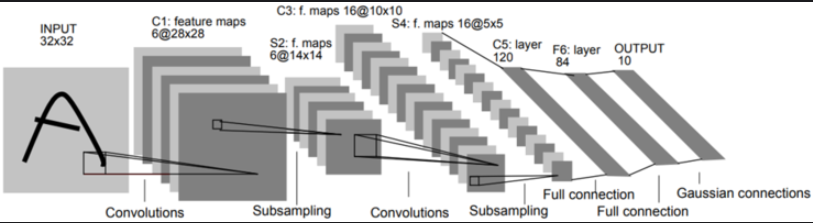

* sigmoid
* subsampling

## AlexNet(2012)

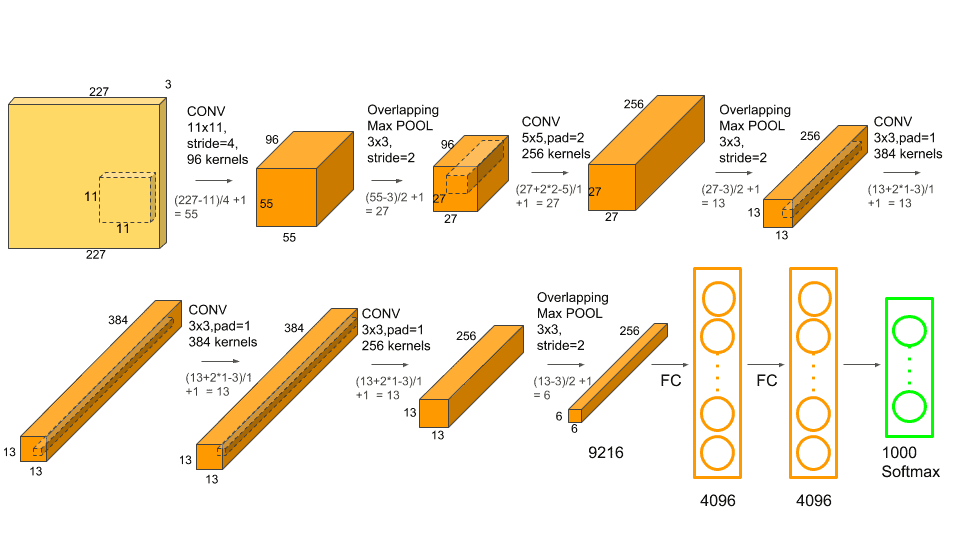

* ReLU
* dropout
* LRN(local normalization)